In [113]:
libraries = c("arrow","tidyverse","readr","scales","purrr","ggpmisc","usmap","reshape2", "data.table", "arrow",
              "tidytext", "lubridate", "MMWRweek", "RColorBrewer")
for(x in libraries) {library(x, character.only=TRUE, warn.conflicts=FALSE, quietly=TRUE)}

'%&%' = function(x,y)paste0(x,y)

theme_set(theme_bw())
version$version.string

[1] "R version 4.3.2 (2023-10-31)"

# Data

In [114]:
schema <- arrow::schema(
  arrow::field("origin_date", arrow::string()),
  arrow::field("scenario_id", arrow::string()),
  arrow::field("location", arrow::string()),
  arrow::field("target", arrow::string()),
  arrow::field("horizon", double()),
  arrow::field("type", arrow::string()),
  arrow::field("type_id", double()),
  arrow::field("model_name", arrow::string()),
  arrow::field("value", double()),
)

In [115]:
##load the data
repo_data <- "../covid19-megaround_data/"
folder_path <- "megaround-processed/"

dc <- arrow::open_dataset(paste0(repo_data, folder_path), partitioning = "model_name", 
                          format = "parquet", schema = schema,
                          factory_options = list(
                            exclude_invalid_files = TRUE))


df_sample <- dplyr::filter(dc, type == "sample" & (target == "inc death" |  target == "inc hosp")) %>% 
  dplyr::collect()


##filter out longer time horizons
df_sample <- df_sample %>% filter(horizon<=104)

##regreate projection date
df_sample <- df_sample %>% mutate(origin_date = lubridate::as_date(origin_date))

##Create a season indicator
##First let's recreate the projection date
df_sample <- df_sample %>%
  mutate(proj_date = origin_date + horizon*7)

##Let's chop up on date. First let's make it based on 4 equa
##week periods
date_cuts <- c("2023-04-15","2024-04-15","2025-05-01")
date_cuts<-lubridate::as_date(date_cuts)
df_sample <- df_sample %>% 
  mutate(period=cut(proj_date, date_cuts, 
                    labels = c("season 2023-24",
                               "season 2024-25")))

In [116]:
prob_list <- c(0.95, 0.75, 0.25, 0.05)

# Peak timing by state

In [117]:
df_sample_date2 <- df_sample %>% group_by(scenario_id, target, model_name, period, type_id, location) %>%
slice(which.max(value)) %>% ungroup()

In [118]:
read.csv("../covid19-scenario-hub_analysis/data-locations/locations.csv") %>% 
dplyr::select(abbreviation, location, population) %>%
mutate(location=as.numeric(location)) -> df_loc

merge(df_sample_date2 %>% mutate(location=as.numeric(location)), 
      df_loc, by=c("location"), all.x=TRUE) %>% 
  filter(!(abbreviation%in%c("AS", "GU", "MP", "PR", "UM", "VI", "US"))) %>% 
dplyr::select(-location) -> df_sample_date2

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”


In [119]:
df_sample_date2 %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2023-24") -> prob_hosp_2023_df2

df_sample_date2 %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2024-25"& proj_date <= as.Date("2025-04-19")) -> prob_hosp_2024_df2

In [120]:
prob_hosp_2023_df2 %>%
  group_by(scenario, abbreviation) %>%
  summarize(mx_median = median(proj_date),
            mx_q95=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q05=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> prob_hosp_2023_boxdf_ensemble

prob_hosp_2024_df2 %>%
  group_by(scenario, abbreviation) %>%
  summarize(mx_median = median(proj_date),
            mx_q95=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q05=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> prob_hosp_2024_boxdf_ensemble

`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'scenario'. You can override using the
`.groups` argument.


In [121]:
library(ggh4x)

df_scales <- data.frame(
  Panel = c("2023-2024", "2024-2025"),
  ymin = c(as.Date("2023-04-01"), as.Date("2024-04-15")),
  ymax = c(as.Date("2024-04-01"), as.Date("2025-04-15"))
)
df_scales <- split(df_scales, df_scales$Panel)

scales <- lapply(df_scales, function(x) {
  scale_y_date(limits = c(x$ymin, x$ymax), date_labels = "%b/%Y", 
               breaks = "4 months", date_minor_breaks = "1 month", expand = c(0, 0))
})

In [122]:
library(ggpubfigs)
pal <- friendly_pal("contrast_three", 51, type = "continuous")

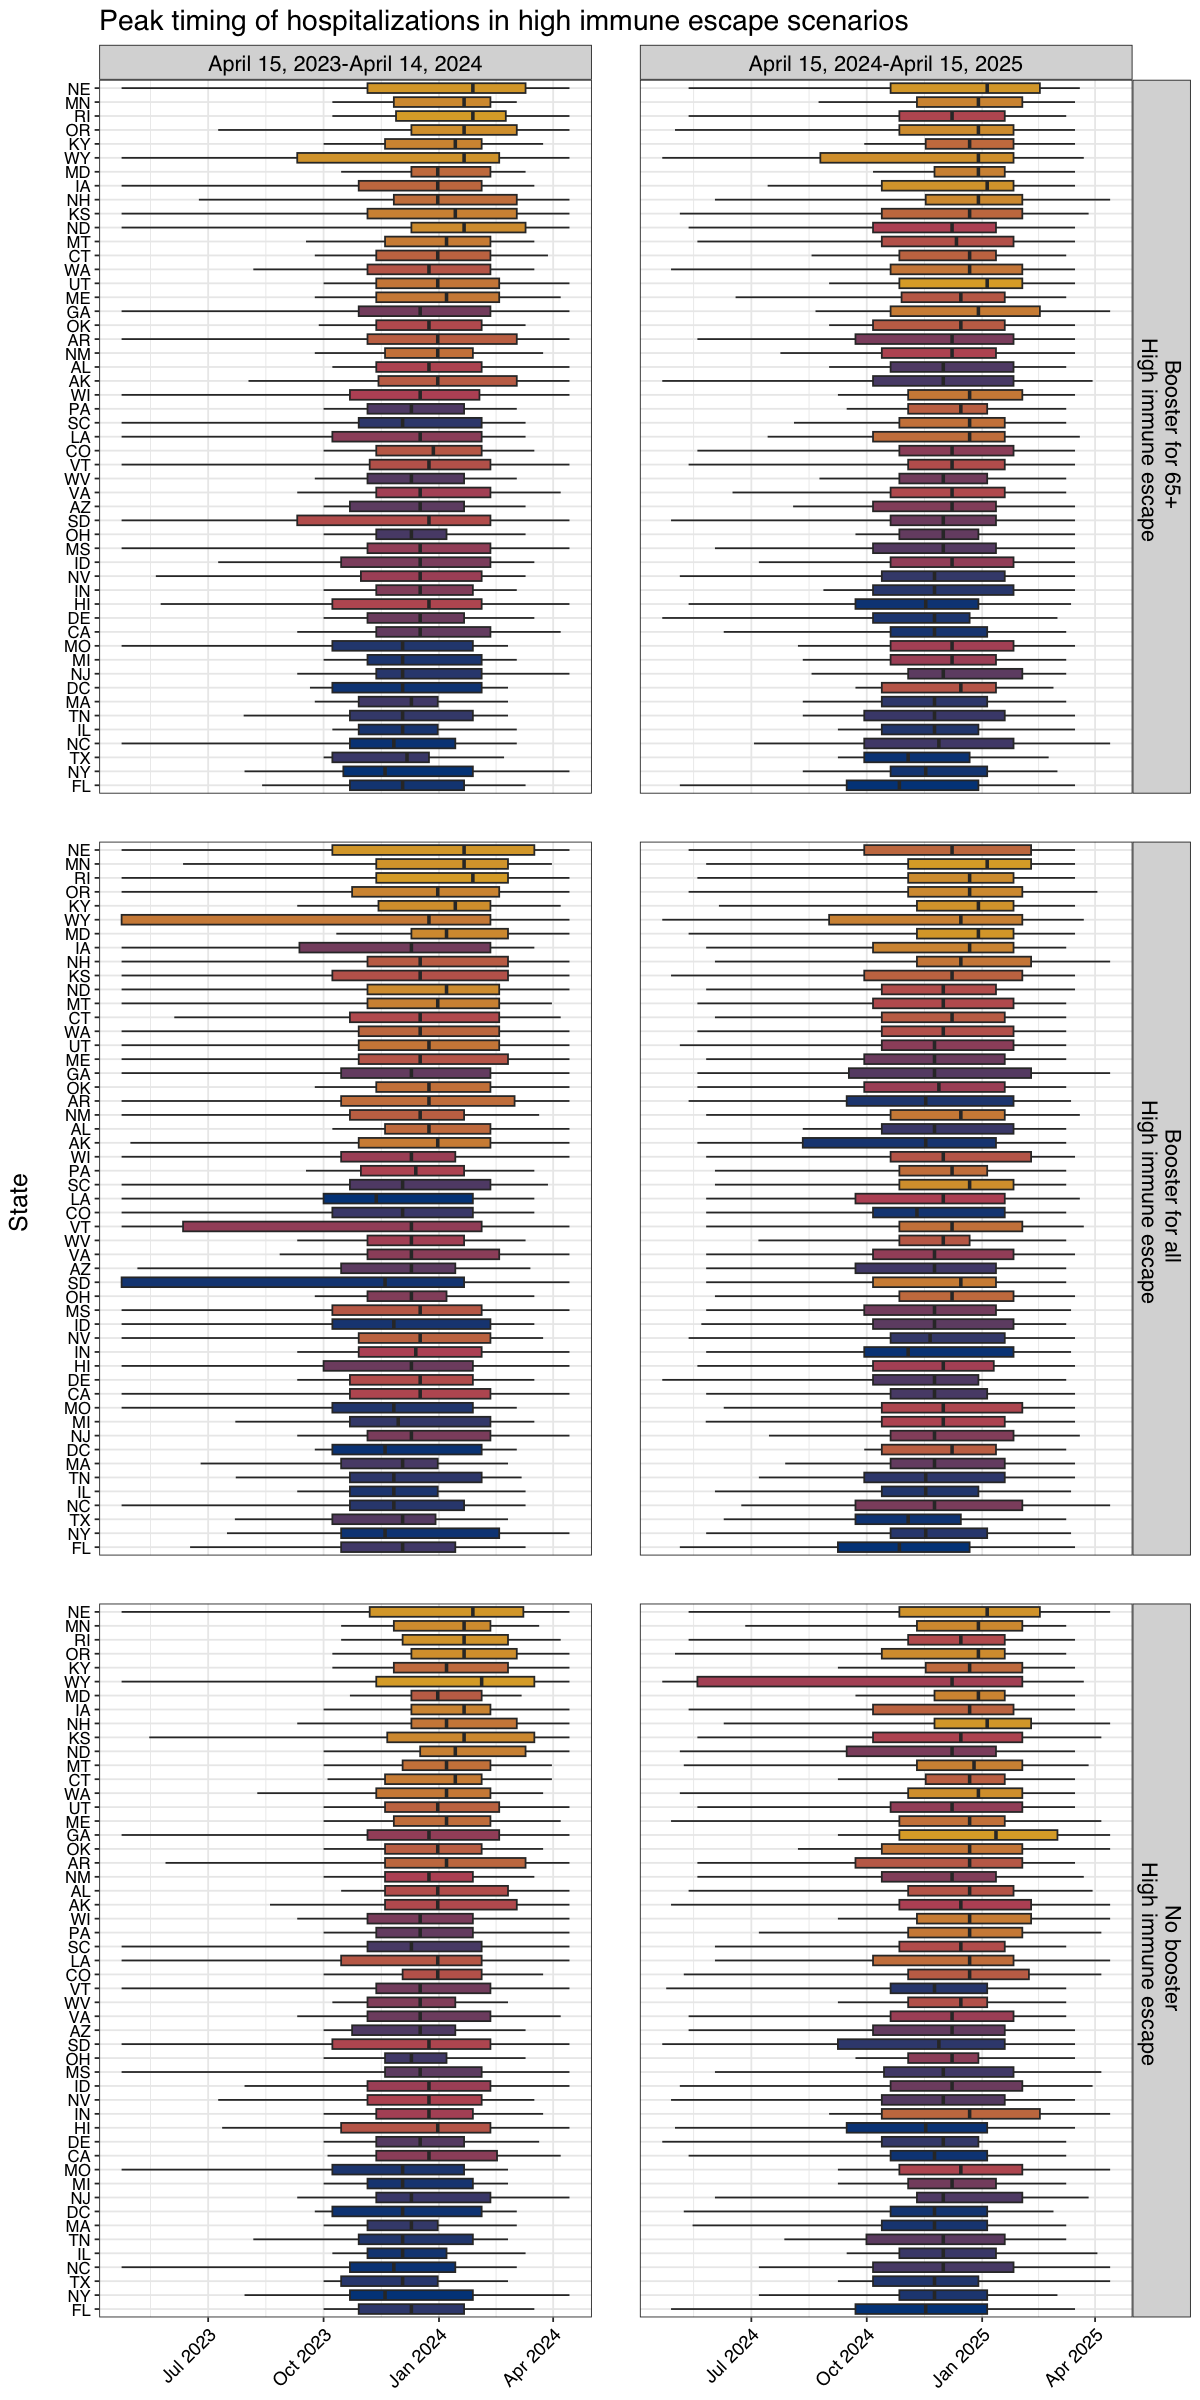

In [123]:
options(repr.plot.width=10,repr.plot.height=20)

rbind(prob_hosp_2023_boxdf_ensemble %>% mutate(season=c("April 15, 2023-April 14, 2024")), 
      prob_hosp_2024_boxdf_ensemble %>% mutate(season=c("April 15, 2024-April 15, 2025"))) %>%
filter(scenario %in% c("No booster \n High immune escape", "Booster for 65+ \n High immune escape",  
                       "Booster for all \n High immune escape")) %>% 
mutate(color=case_when(season==c("April 15, 2023-April 14, 2024")~as.numeric(mx_median-as.Date("2023-10-15")),
                       season==c("April 15, 2024-April 15, 2025")~as.numeric(mx_median-as.Date("2024-10-15")))) %>%
group_by(scenario, season) %>% arrange(color) %>% mutate(color_order=order(color)) %>% ungroup() %>%
ggplot(aes(x=reorder(abbreviation, mx_median, group=season), fill=color_order))+
geom_boxplot(aes(ymin=mx_q05, lower=mx_q25, middle=mx_median, upper=mx_q75, ymax=mx_q95),
             stat="identity", position = "dodge", width=0.7) +  
facet_grid(rows=vars(scenario), cols=vars(season), scales = "free")+
scale_fill_gradientn(colours=pal)+
coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.y = element_text(size=10, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
labs(x="State \n", title="Peak timing of hospitalizations in high immune escape scenarios") -> Fig_timing_state

Fig_timing_state

ggsave("Figures/Final_figures/FigureS3.tiff", Fig_timing_state, width=10, height=20, dpi=300)

In [124]:
df_sample_date <- df_sample %>% filter(location=="US") %>% 
group_by(scenario_id, target, model_name, period, type_id) %>%
slice(which.max(value)) %>% ungroup()


df_sample_date %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2023-24") -> prob_hosp_2023_df

df_sample_date %>% filter(target=="inc hosp") %>%
mutate(scenario=recode(scenario_id, 
                       "A-2023-04-16" = "No booster \n Low immune escape", 
                       "B-2023-04-16" = "No booster \n High immune escape", 
                       "C-2023-04-16"="Booster for 65+ \n Low immune escape", 
                       "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                       "E-2023-04-16"="Booster for all \n Low immune escape",
                       "F-2023-04-16"="Booster for all \n High immune escape")) %>%
filter(period=="season 2024-25"& proj_date <= as.Date("2025-04-19")) -> prob_hosp_2024_df


prob_hosp_2023_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(proj_date),
            mx_q95=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q05=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> prob_hosp_2023_boxdf_ensemble

prob_hosp_2024_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(proj_date),
            mx_q95=as.Date(quantile(unclass(proj_date),prob_list[1]), origin=("1970-01-01")),
            mx_q75=as.Date(quantile(unclass(proj_date),prob_list[2]), origin=("1970-01-01")),
            mx_q25=as.Date(quantile(unclass(proj_date),prob_list[3]), origin=("1970-01-01")),
            mx_q05=as.Date(quantile(unclass(proj_date),prob_list[4]), origin=("1970-01-01")))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> prob_hosp_2024_boxdf_ensemble

rbind(prob_hosp_2023_boxdf_ensemble %>% mutate(season=c("2023-2024 season")), 
      prob_hosp_2024_boxdf_ensemble %>% mutate(season=c("2024-2025 season"))) %>%
filter(model_name==c("Ensemble")) -> peak_timing_ensemble



prob_hosp_2023_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(value),
            mx_q95=quantile(unclass(value),prob_list[1]),
            mx_q75=quantile(unclass(value),prob_list[2]),
            mx_q25=quantile(unclass(value),prob_list[3]),
            mx_q05=quantile(unclass(value),prob_list[4]))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> size_hosp_2023_boxdf_ensemble

prob_hosp_2024_df %>%
  group_by(scenario) %>%
  summarize(mx_median = median(value),
            mx_q95=quantile(unclass(value),prob_list[1]),
            mx_q75=quantile(unclass(value),prob_list[2]),
            mx_q25=quantile(unclass(value),prob_list[3]),
            mx_q05=quantile(unclass(value),prob_list[4]))%>%
  ungroup() %>% mutate(model_name=c("Ensemble")) -> size_hosp_2024_boxdf_ensemble

rbind(size_hosp_2023_boxdf_ensemble %>% mutate(season=c("2023-2024 season")), 
      size_hosp_2024_boxdf_ensemble %>% mutate(season=c("2024-2025 season"))) %>%
filter(model_name==c("Ensemble")) -> peak_size_ensemble

In [125]:
interval <- c("mx_q95", "mx_q05")

peak_timing_ensemble %>% dplyr::rename(timing_med=mx_median, timing_ub=interval[1], timing_lb=interval[2]) %>%
dplyr::select(scenario, season, timing_lb, timing_med, timing_ub) -> timing_table

peak_size_ensemble %>% dplyr::rename(size_med=mx_median, size_ub=interval[1], size_lb=interval[2]) %>%
dplyr::select(scenario, season, size_lb, size_med, size_ub) -> size_table


timing_table %>% filter(season==c("2023-2024 season")) %>%
mutate(timing=paste0(format(timing_med, format=c("%b%d"))," (",format(timing_lb, format=c("%b%d")),"-",
                     format(timing_ub, format=c("%b%d")),")")) %>%
dplyr::select(scenario, season, timing)

timing_table %>% filter(season==c("2024-2025 season")) %>%
mutate(timing=paste0(format(timing_med, format=c("%b%d"))," (",format(timing_lb, format=c("%b%d")),"-",
                     format(timing_ub, format=c("%b%d")),")")) %>%
dplyr::select(scenario, season, timing)


size_table %>% filter(season==c("2023-2024 season")) %>%
mutate(size=paste0(round(size_med, -3)," (", round(size_lb, -3), "-", round(size_ub, -3), ")")) %>%
dplyr::select(scenario, season, size)


size_table %>% filter(season==c("2024-2025 season")) %>%
mutate(size=paste0(round(size_med, -3)," (", round(size_lb, -3), "-", round(size_ub, -3), ")")) %>%
dplyr::select(scenario, season, size)

scenario,season,timing
<chr>,<chr>,<chr>
Booster for 65+ High immune escape,2023-2024 season,Dec10 (Oct15-Feb07)
Booster for 65+ Low immune escape,2023-2024 season,Dec10 (Aug13-Feb18)
Booster for all High immune escape,2023-2024 season,Dec10 (Oct08-Feb18)
Booster for all Low immune escape,2023-2024 season,Dec03 (Apr30-Mar03)
No booster High immune escape,2023-2024 season,Dec10 (Oct15-Apr14)
No booster Low immune escape,2023-2024 season,Dec13 (Aug13-Apr14)


scenario,season,timing
<chr>,<chr>,<chr>
Booster for 65+ High immune escape,2024-2025 season,Dec15 (Oct13-Feb23)
Booster for 65+ Low immune escape,2024-2025 season,Dec22 (Oct27-Mar09)
Booster for all High immune escape,2024-2025 season,Dec08 (Jun09-Feb19)
Booster for all Low immune escape,2024-2025 season,Dec15 (Jun12-Mar09)
No booster High immune escape,2024-2025 season,Dec15 (Oct13-Apr13)
No booster Low immune escape,2024-2025 season,Dec29 (Oct27-Apr13)


scenario,season,size
<chr>,<chr>,<chr>
Booster for 65+ High immune escape,2023-2024 season,39000 (17000-91000)
Booster for 65+ Low immune escape,2023-2024 season,34000 (15000-68000)
Booster for all High immune escape,2023-2024 season,35000 (15000-91000)
Booster for all Low immune escape,2023-2024 season,26000 (13000-57000)
No booster High immune escape,2023-2024 season,42000 (18000-105000)
No booster Low immune escape,2023-2024 season,36000 (16000-81000)


scenario,season,size
<chr>,<chr>,<chr>
Booster for 65+ High immune escape,2024-2025 season,41000 (16000-77000)
Booster for 65+ Low immune escape,2024-2025 season,32000 (13000-65000)
Booster for all High immune escape,2024-2025 season,32000 (14000-77000)
Booster for all Low immune escape,2024-2025 season,28000 (12000-51000)
No booster High immune escape,2024-2025 season,45000 (17000-90000)
No booster Low immune escape,2024-2025 season,35000 (14000-76000)


# National cumulative hospitalizations and deaths

In [126]:
dir_path <- c("../covid19-scenario-hub_analysis/")
data_path <- c("../covid19-megaround_data/")


## choose scenario identifier and appropriate hosp file
scenario.id="04-16"
projection.start.date="2023-04-15"
projection.end.date <- "2025-04-19"
round <- 17
ens_choice <- "Ensemble_LOP"
pi_low <- 0.025
pi_high <- 0.975  

model_names <- c("Ensemble",
                 "Ensemble_LOP",
                 "Ensemble_LOP_untrimmed",
                 "JHU_IDD-CovidSP",
                 "MOBS_NEU-GLEAM_COVID",
                 "NCSU-COVSIM",
                 "NotreDame-FRED",
                 "UNCC-hierbin",
                 "USC-SIkJalpha",
                 "UTA-ImmunoSEIRS",
                 "UVA-adaptive",
                 "UVA-EpiHiper")

source("../covid19-scenario-hub_analysis/code/R/read_data_files.R", local = knitr::knit_global())
source("../covid19-scenario-hub_analysis/code/report/collect_data_update.R", local = knitr::knit_global())

# Scenario name information - UPDATE EACH ROUND
axis1 <- c("noBoo", "65Boo", "allBoo")
axis2 <- c("lowIE", "highIE")
axis1_long <- c("No booster", "Booster for 65+", "Booster for all")
axis2_long <- c("Low immune escape", "High immune escape") 
var_name1 <- "IE"
var_name2 <- "boo"
pessimistic <- "noBoo_highIE" # most pessimistic scenario to use for risk maps

s1.1 <- paste(axis1[1], axis2[1], sep = "_")
s2.1 <- paste(axis1[2], axis2[1], sep = "_")
s3.1 <- paste(axis1[3], axis2[1], sep = "_")
s1.2 <- paste(axis1[1], axis2[2], sep = "_")
s2.2 <- paste(axis1[2], axis2[2], sep = "_")
s3.2 <- paste(axis1[3], axis2[2], sep = "_")

# some columns to use for plotting
x_ci$model <- factor(x_ci$model, levels = model_names)
x_ci$scenario_name <- recode(x_ci$scenario_id,
                             "A-2023-04-16" = "noBoo_lowIE",
                             "B-2023-04-16" = "noBoo_highIE",
                             "C-2023-04-16" = "65Boo_lowIE",
                             "D-2023-04-16" = "65Boo_highIE",
                             "E-2023-04-16" = "allBoo_lowIE",
                             "F-2023-04-16" = "allBoo_highIE")

x_ci$a1 <- ifelse(x_ci$scenario_name %in% c(s1.1, s1.2), axis1_long[1],
                  ifelse(x_ci$scenario_name %in% c(s2.1, s2.2), axis1_long[2], axis1_long[3]))
x_ci$a1 <- factor(x_ci$a1, levels =c(axis1_long[1], axis1_long[2], axis1_long[3]))
x_ci$a2 <- ifelse(x_ci$scenario_name %in% c(s1.1, s2.1, s3.1), axis2_long[1], axis2_long[2])
x_ci$a2 <- factor(x_ci$a2, levels = c(axis2_long[1], axis2_long[2]))
x_ci$full_scenario <- paste(x_ci$a1, x_ci$a2, sep = ", ")

x$model <- factor(x$model, levels = model_names)
x$scenario_name <- recode(x$scenario_id,
                          "A-2023-04-16" = "noBoo_lowIE",
                          "B-2023-04-16" = "noBoo_highIE",
                          "C-2023-04-16" = "65Boo_lowIE",
                          "D-2023-04-16" = "65Boo_highIE",
                          "E-2023-04-16" = "allBoo_lowIE",
                          "F-2023-04-16" = "allBoo_highIE")
x$a1 <- ifelse(x$scenario_name %in% c(s1.1, s1.2), axis1_long[1],
               ifelse(x$scenario_name %in% c(s2.1, s2.2), axis1_long[2], axis1_long[3]))
x$a1 <- factor(x$a1, levels =c(axis1_long[1], axis1_long[2], axis1_long[3]))
x$a2 <- ifelse(x$scenario_name %in% c(s1.1, s2.1, s3.1), axis2_long[1], axis2_long[2])
x$a2 <- factor(x$a2, levels = c(axis2_long[1], axis2_long[2]))
x$full_scenario <- paste(x$a1, x$a2, sep = ", ")

# filter out projections beyond 26 weeks
x <- x %>% filter(target_end_date <= as.Date(projection.end.date))
x_ci <- x_ci %>% filter(target_end_date <= as.Date(projection.end.date))

Loading required package: reshape

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘reshape’”
Joining with `by = join_by(location)`
Joining with `by = join_by(origin_date, scenario_id, location, target, horizon,
model, target_end_date, abbreviation, location_name, population, target_type)`
Joining with `by = join_by(origin_date, scenario_id, location, target, horizon,
model, target_end_date, abbreviation, location_name, population, target_type)`
Loading required package: reshape

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘reshape’”


In [127]:
(65745.69-32872.85)/2+32872.85

[1] 49309.27

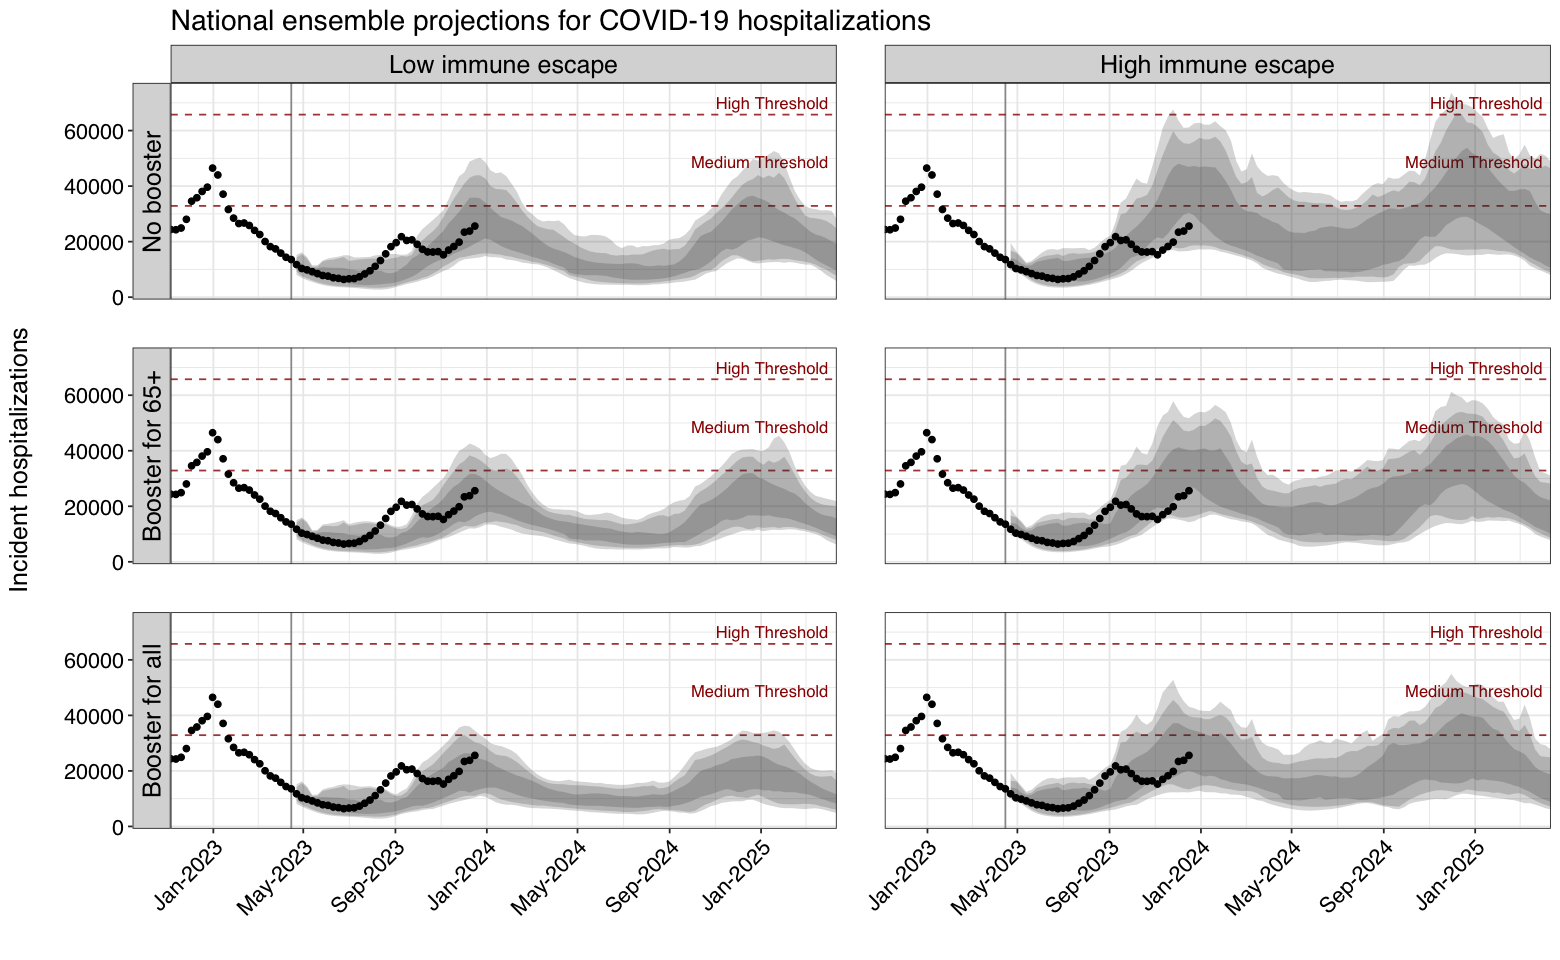

In [132]:
targets <- c("Hospitalizations", "Deaths")
lev <- unique(loc$location_name) 

v_line = data.frame(x = as.numeric(as.Date(projection.start.date)),
                    y = Inf,
                    lab = paste0("Projections begin\n",projection.start.date),
                    target_type = "Hospitalizations")

#define CDC community transmission thresholds
h_line_medthr = data.frame(x = Inf,
                           y = 32872.85,
#                            lab = paste0("Medium Threshold: 32873"),
                           lab = paste0("Medium Threshold"),
                           target_type = "Hospitalizations")

h_line_medtext = data.frame(x = Inf,
#                             y = (65745.69-32872.85)/2+32872.85,
                            y = 44500,
#                            lab = paste0("Medium Threshold: 32873"),
                           lab = paste0("Medium Threshold"),
                           target_type = "Hospitalizations")

h_line_highthr = data.frame(x = Inf,
                            y = 65745.69,
#                             lab = paste0("High Threshold: 65746"),
                            lab = paste0("High Threshold"),
                            target_type = "Hospitalizations")
temp <- x %>%
filter(model == "Ensemble", type == "quantile", str_detect(target, "inc"), 
       abbreviation == "US", target_type == "Hospitalizations") %>%
pivot_wider(names_from = quantile, names_prefix = "q")
  
temp_thresholds <- filter(rbind(h_line_medthr,h_line_highthr), target_type == "Hospitalizations")
temp_thresholds2 <- filter(rbind(h_line_medtext,h_line_highthr), target_type == "Hospitalizations")
temp_mod_lab <- filter(h_line_medthr, target_type == "Hospitalizations")
temp_high_lab <- filter(h_line_highthr, target_type == "Hospitalizations")
breaks <- seq(as.Date("2020-01-01"), as.Date(projection.end.date), "4 month")

options(repr.plot.width=13,repr.plot.height=8)

temp %>%
ggplot() +
geom_vline(data = v_line %>% dplyr::select(-target_type), aes(xintercept = x), color = "grey60")+
# geom_text(data = v_line, aes(x = x, y = y, label = lab), hjust = 0, vjust = 1, size = 4)+
geom_hline(data = temp_thresholds, aes(yintercept = y), color = "#990000", linetype = 2, alpha = 0.8) +
geom_text(data = temp_thresholds2, aes(x = as.Date("2025-04-01"), y = y, label = lab, family="sans"), 
          color = "#990000", hjust = "right", vjust = -0.5, size = 3.5) +
geom_ribbon(aes(x = target_end_date, ymin = q0.05, ymax = q0.95), alpha = 0.2) +
geom_ribbon(aes(x = target_end_date, ymin = q0.1, ymax = q0.9), alpha = 0.2) +
geom_ribbon(aes(x = target_end_date, ymin = q0.25, ymax = q0.75), alpha = 0.2) +
geom_point(data = filter(truth, location == "US", target_type == "Hospitalizations", 
                         date >= as.Date("2022-11-01"), date <= as.Date("2023-12-16")), 
           size = 1.5, aes(x = date, y = value)) +
facet_grid(cols = vars(a2), rows = vars(a1), switch = "y") +
theme_bw() +
labs(x = "", y = "Incident hospitalizations \n") +
scale_x_continuous(breaks = breaks, expand = c(0, 0), labels = format(breaks, "%b-%Y")) +
ggtitle(paste0("National ensemble projections for COVID-19 hospitalizations")) +
theme(text = element_text(size=15, family="sans",color="black"),
axis.text = element_text(size=13, family="sans",color="black"),
plot.title = element_text(size=17, family="sans",color="black"),
strip.text = element_text(size = 15, family="sans",color="black"),
axis.title.y = element_text(size=15, family="sans",color="black"),
axis.text.x = element_text(angle=45, hjust=1), 
legend.position = "none",    
panel.spacing = unit(2, "lines")) -> projection_fig
projection_fig

ggsave("Figures/Final_figures/Figure1.tiff", projection_fig, width=13, height=8, dpi=300)

In [133]:
truth %>% filter(location == "US", target_type == "Hospitalizations") %>% slice(which.max(date))

target,date,location_name,location,value,target_type
<chr>,<IDate>,<chr>,<chr>,<int>,<chr>
hospitalization,2023-12-30,US,US,35866,Hospitalizations


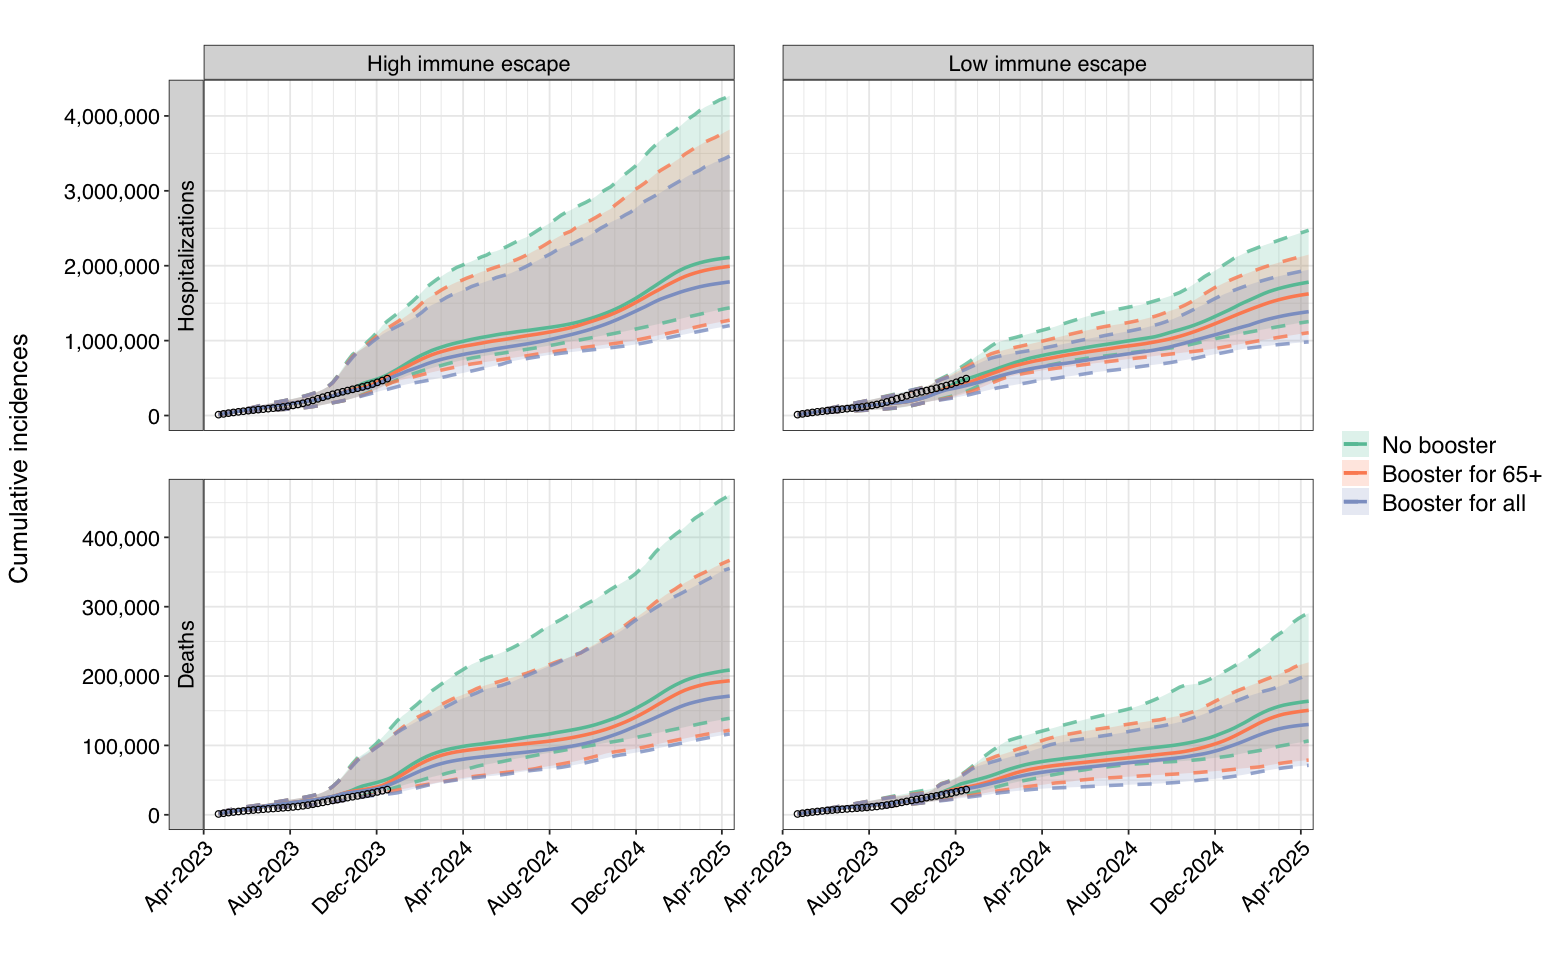

In [134]:
temp <- x %>% filter(model == "Ensemble", type == "quantile", target %in% c("cum death", "cum hosp"), 
                     abbreviation == "US") %>% pivot_wider(names_from = quantile, names_prefix = "q")

options(repr.plot.width=13,repr.plot.height=8)

truth %>% filter(location == "US", date >= min(temp$target_end_date)) -> temp_compare
rbind(temp_compare, temp_compare) %>% as.data.frame() %>% 
mutate(a2=rep(c("Low immune escape", "High immune escape"), each=nrow(temp_compare))) %>%
group_by(target_type, a2) %>% mutate(cum_value=cumsum(value)) %>% ungroup() -> temp_compare_all

ggplot() +
geom_ribbon(data = temp, aes(x = target_end_date, ymin = q0.05, ymax = q0.95, fill = a1), alpha = 0.2) +
geom_line(data = temp,  aes(x = target_end_date, y = q0.05, color = a1), size = 1, linetype=2, alpha = 0.8) +
geom_line(data = temp,  aes(x = target_end_date, y = q0.95, color = a1), size = 1, linetype=2, alpha = 0.8) +
geom_line(data = temp,  aes(x = target_end_date, y = q0.5, color = a1), size = 1) +
geom_point(data = temp_compare_all %>% filter(date <= as.Date("2023-12-16")), size = 1.5, shape=1, aes(x = date, y = cum_value)) +
facet_grid(cols = vars(a2), 
         rows = vars(factor(target_type, levels = c("Hospitalizations", "Deaths"))), 
         switch = "y", scales = "free_y") +
scale_color_brewer("", palette = "Set2")  +
scale_fill_brewer("", palette = "Set2") +
scale_y_continuous(label=comma)+
scale_x_date(date_labels = "%b-%Y", breaks = "4 months", date_minor_breaks = "1 month",
         limits=c(as.Date("2023-04-01"), as.Date("2025-04-19")), expand = c(0, 0)) +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=13, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
labs(x="", y="Cumulative incidences \n", title="")  -> cum_cases

cum_cases
ggsave("Figures/Final_figures/FigureS1.tiff", cum_cases, width=13, height=8, dpi=300)

# Figure 2: Prevented outcomes

In [91]:
##load the data
repo_data <- "../covid19-megaround_data/"
folder_path <- "megaround-processed/"

dc <- arrow::open_dataset(paste0(repo_data, folder_path), partitioning = "model_name", 
                          format = "parquet", schema = schema,
                          factory_options = list(
                            exclude_invalid_files = TRUE))


df_sample <- dplyr::filter(dc, type == "sample" & (target == "inc death" |  target == "inc hosp")) %>% 
  dplyr::collect()


##filter out longer time horizons
df_sample <- df_sample %>% filter(horizon<=104)

##regreate projection date
df_sample <- df_sample %>% mutate(origin_date = lubridate::as_date(origin_date))

In [92]:
res_summary <- df_sample %>%
  group_by(scenario_id, model_name, target, location, type_id)%>%
  summarize(tot=sum(value))%>%
  ungroup()%>%
  group_by(scenario_id, model_name, target, location)%>%
  summarize(scn_mn = mean(tot), scn_se=sd(tot)/sqrt(n()))%>%
  ungroup()

## within each level of immune escape.
res_summary <- res_summary %>%
  mutate(imm_escape = ifelse(scenario_id%in%c("A-2023-04-16","C-2023-04-16", "E-2023-04-16"), "Low","High"),
         vax_lvl = ifelse(scenario_id%in%c("A-2023-04-16","B-2023-04-16"), "no boost",
                          ifelse(scenario_id%in%c("C-2023-04-16","D-2023-04-16"),"65+", "all")))

`summarise()` has grouped output by 'scenario_id', 'model_name', 'target',
'location'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'scenario_id', 'model_name', 'target'. You
can override using the `.groups` argument.


In [93]:
read.csv("../covid19-scenario-hub_analysis/data-locations/locations.csv") %>% 
dplyr::select(abbreviation, location, population) %>%
mutate(location=as.numeric(location)) -> df_loc

read.csv("../covid19-scenario-hub_analysis/data-locations/locations.csv") %>% 
filter(!(abbreviation%in%c("US", "AS", "GU", "MP", "PR", "UM", "VI"))) %>%
mutate(USpopsize=sum(population)) -> temp_pop
as.numeric(unique(temp_pop$USpopsize)) -> USpopsize

merge(res_summary %>% mutate(location=as.numeric(location)), 
      df_loc, by=c("location"), all.x=TRUE) %>% 
  filter(!(abbreviation%in%c("AS", "GU", "MP", "PR", "UM", "VI"))) %>% dplyr::select(-location) %>%
mutate(population=case_when(abbreviation==c("US")~USpopsize, TRUE~population)) -> res_summary_loc

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `location = as.numeric(location)`.
Caused by warning:
! NAs introduced by coercion”


In [94]:
##Pivot wider
res_summary_wide <- res_summary_loc %>% 
  select(-scenario_id) %>%
  pivot_wider(names_from=vax_lvl, values_from = c(scn_mn, scn_se))

In [95]:
se_ratio <- function (mn1, mn2, se1, se2) {
  mn1/mn2 * sqrt((se1/mn1)^2 + (se2/mn2)^2)
}

In [96]:
res_compares <- res_summary_wide %>%
  mutate(no_65plus_mn_diff = `scn_mn_no boost`-`scn_mn_65+`,
         no_65plus_se_diff = sqrt(`scn_se_no boost`^2+`scn_se_65+`^2),
         no_all_mn_diff = `scn_mn_no boost`-`scn_mn_all`,
         no_all_se_diff = sqrt(`scn_se_no boost`^2+`scn_se_all`^2),
         `65plus_all_mn_diff` = `scn_mn_65+`-`scn_mn_all`,
         `65plus_all_se_diff` = sqrt(`scn_se_65+`^2+`scn_se_all`^2),
         no_65plus_mn_rel = `scn_mn_65+`/`scn_mn_no boost`,
         no_65plus_se_rel = se_ratio(`scn_mn_65+`, `scn_mn_no boost`, `scn_se_65+`,`scn_se_no boost`),
         no_all_mn_rel = `scn_mn_all`/`scn_mn_no boost`,
         no_all_se_rel = se_ratio(`scn_mn_all`,`scn_mn_no boost`,  `scn_se_all`, `scn_se_no boost`),
         `65plus_all_mn_rel` = `scn_mn_all`/`scn_mn_65+`,
         `65plus_all_se_rel` = se_ratio(`scn_mn_all`,`scn_mn_65+`,`scn_se_all`, `scn_se_65+`)) %>%
  select(model_name, target, abbreviation, imm_escape,
         no_65plus_mn_diff, no_all_mn_diff,`65plus_all_mn_diff`,
         no_65plus_se_diff, no_all_se_diff,`65plus_all_se_diff`,
         no_65plus_mn_rel, no_all_mn_rel,`65plus_all_mn_rel`,
         no_65plus_se_rel, no_all_se_rel,`65plus_all_se_rel`)

In [97]:
res_compares_lng <-  res_compares %>%
  pivot_longer(cols=c(no_65plus_mn_diff,
                      no_65plus_se_diff,
                      no_all_mn_diff,
                      no_all_se_diff,
                      `65plus_all_mn_diff`,
                      `65plus_all_se_diff`,
                      no_65plus_mn_rel,
                      no_65plus_se_rel,
                      no_all_mn_rel,
                      no_all_se_rel,
                      `65plus_all_mn_rel`,
                      `65plus_all_se_rel`)) %>%
  mutate(measure=ifelse(stringr::str_detect(name,"mn"),"mn","se"),
         diff_rel = ifelse(stringr::str_detect(name,"diff"),"diff","rel"),
         compare=ifelse(stringr::str_detect(name,"no_all"), "None vs All",
                        ifelse(stringr::str_detect(name,"no_65plus"), "None vs 65+", "65+ vs All")),
         target_labs=ifelse(stringr::str_detect(target, "inc death"), "Deaths", "Hospitalizations")) %>%
  select(-name)%>%
  pivot_wider(values_from = value, names_from = measure)

In [98]:
res_compares_lng %>% filter(abbreviation=="US") -> res_compares_lng_US

In [99]:
## Gdt the random effect models for each level.
cex_val = 1
refline = 0
outcome_string  = "(Number Averted)"
tgt_vec <- c("Hospitalizations", "Deaths")
state_vec <- unique(res_compares_lng$abbreviation)

In [100]:
values <- list()
meta_res_abs <- tibble()
for(state in state_vec){
    values[[state]] <- list()
    for (imm_esc in c("Low", "High")){
      values[[state]][[imm_esc]] <- list()
      for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
        values[[state]][[imm_esc]][[comparison]] <- list()
        for (tgt in tgt_vec){
          outcome_col_i <- which(tgt_vec == tgt)
          meta <- metafor::rma.uni(yi=mn, sei=se,
                                   data=filter(res_compares_lng , str_detect(target, "inc") &
                                               abbreviation==state & imm_escape==imm_esc &
                                               target_labs==tgt & compare==comparison &
                                               diff_rel=="rel" & mn > 0),
                                   control=list(stepadj=0.5, maxiter=10000))

          values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta
            
          meta_res_abs <- meta_res_abs %>% bind_rows( 
              tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                     state = state,
                     mean = as.numeric(meta[["b"]]),
                     lb = meta[["ci.lb"]],
                     ub = meta[["ci.ub"]],
                     se = meta[["se"]],
                     n_ests = length(meta[["yi"]])))
        }
      }
    }
}

merge(meta_res_abs, df_loc %>% dplyr::rename(state=abbreviation) %>% dplyr::select(state, population), 
      by=c("state"), all.x=TRUE) %>% 
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low immune escape"), 
                         imm_esc==c("High")~c("High immune escape"))) -> meta_res_rel

Warning message:
“Fisher scoring algorithm may have gotten stuck at a local maximum.
Setting tau^2 = 0. Check the profile likelihood plot with profile().”


In [101]:
values <- list()
meta_res_abs <- tibble()
for(state in state_vec){
    values[[state]] <- list()
    for (imm_esc in c("Low", "High")){
      values[[state]][[imm_esc]] <- list()
      for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
        values[[state]][[imm_esc]][[comparison]] <- list()
        for (tgt in tgt_vec){
          outcome_col_i <- which(tgt_vec == tgt)
          meta <- metafor::rma.uni(yi=mn, sei=se,
                                   data=filter(res_compares_lng , str_detect(target, "inc") &
                                               abbreviation==state & imm_escape==imm_esc &
                                               target_labs==tgt & compare==comparison &
                                               diff_rel=="diff" & mn > 0),
                                   control=list(stepadj=0.5, maxiter=10000))

          values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta
            
          meta_res_abs <- meta_res_abs %>% bind_rows( 
              tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                     state = state,
                     mean = as.numeric(meta[["b"]]),
                     lb = meta[["ci.lb"]],
                     ub = meta[["ci.ub"]],
                     se = meta[["se"]],
                     n_ests = length(meta[["yi"]])))
        }
      }
    }
}

merge(meta_res_abs, df_loc %>% dplyr::rename(state=abbreviation) %>% dplyr::select(state, population), 
      by=c("state"), all.x=TRUE) %>% 
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low immune escape"), 
                         imm_esc==c("High")~c("High immune escape"))) -> meta_res_abs

In [102]:
values <- list()
meta_res_abs_national <- tibble()
for (imm_esc in c("Low", "High")){
  values[[state]][[imm_esc]] <- list()
  for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
    values[[state]][[imm_esc]][[comparison]] <- list()
    for (tgt in tgt_vec){
      outcome_col_i <- which(tgt_vec == tgt)
      meta <- metafor::rma.uni(yi=mn, sei=se,
                               data=filter(res_compares_lng_US , str_detect(target, "inc") &
                                           imm_escape==imm_esc & target_labs==tgt & 
                                           compare==comparison & diff_rel=="rel"),
                               control=list(stepadj=0.5, maxiter=10000))

      values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta

      meta_res_abs_national <- meta_res_abs_national %>% bind_rows( 
          tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                 state = c("US"),
                 mean = as.numeric(meta[["b"]]),
                 lb = meta[["ci.lb"]],
                 ub = meta[["ci.ub"]],
                 se = meta[["se"]],
                 n_ests = length(meta[["yi"]])))
    }
  }
}

meta_res_abs_national %>%
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low immune escape"), 
                         imm_esc==c("High")~c("High immune escape"))) -> meta_res_rel_national

In [103]:
values <- list()
meta_res_abs_national <- tibble()
for (imm_esc in c("Low", "High")){
  values[[state]][[imm_esc]] <- list()
  for (comparison in c("None vs 65+","None vs All","65+ vs All")) {
    values[[state]][[imm_esc]][[comparison]] <- list()
    for (tgt in tgt_vec){
      outcome_col_i <- which(tgt_vec == tgt)
      meta <- metafor::rma.uni(yi=mn, sei=se,
                               data=filter(res_compares_lng_US , str_detect(target, "inc") &
                                           imm_escape==imm_esc & target_labs==tgt & 
                                           compare==comparison & diff_rel=="diff"),
                               control=list(stepadj=0.5, maxiter=10000))

      values[[state]][[imm_esc]][[comparison]][[tgt]] <- meta

      meta_res_abs_national <- meta_res_abs_national %>% bind_rows( 
          tibble(comp = comparison, imm_esc = imm_esc, target = tgt, 
                 state = c("US"),
                 mean = as.numeric(meta[["b"]]),
                 lb = meta[["ci.lb"]],
                 ub = meta[["ci.ub"]],
                 se = meta[["se"]],
                 n_ests = length(meta[["yi"]])))
    }
  }
}

meta_res_abs %>% filter(target==c("Hospitalizations") & 
                        imm_esc==c("Low Immune Escape") & comp==c("None vs All")) -> temp
meta_res_abs_national %>% mutate(population=sum(temp$population)) %>%
mutate(imm_esc=case_when(imm_esc==c("Low")~c("Low immune escape"), 
                         imm_esc==c("High")~c("High immune escape"))) %>%
mutate(value=mean/population*100000) -> meta_res_abs_national

In [104]:
## figure by model
theme_set(theme_bw())
options(repr.plot.width=8,repr.plot.height=10)

meta_res_rel_national %>%
mutate(comp=case_when(comp==c("None vs All")~c("All vs None"),
                      comp==c("None vs 65+")~c("65+ vs None"), 
                      comp==c("65+ vs All")~c("All vs 65+"))) -> meta_res_rel_fig

meta_res_rel_fig$target <- factor(meta_res_rel_fig$target, levels=c("Hospitalizations", "Deaths"))
meta_res_rel_fig$comp <- factor(meta_res_rel_fig$comp, levels=c("All vs 65+",  "All vs None", "65+ vs None"))
meta_res_rel_fig$imm_esc <- factor(meta_res_rel_fig$imm_esc, levels=c("Low immune escape", "High immune escape"))

meta_res_rel_fig %>% mutate(table=paste0(format(round((1-mean)*100,0), nsmall=0),"%"," (",
                                         format(round((1-ub)*100,0), nsmall=0),"-",
                                         format(round((1-lb)*100,0), nsmall=0),"%",")")) %>%
ggplot(aes(y=comp))+
facet_wrap(~target, nrow = 2)+
geom_errorbarh(aes(xmin = 1-lb, xmax = 1-ub, group=imm_esc, color=imm_esc), 
               stat="identity", position = position_dodge(width = 0.9), height = .2) +
geom_point(aes(x = 1-mean, group=imm_esc, color=imm_esc), 
           stat="identity", position = position_dodge(width = 0.9), size = 3, pch = 16) +
geom_text(aes(x = 1-mean, label = table, group = imm_esc),
          stat="identity", position = position_dodge(width = 1), vjust = -0.9, height = .2, size = 4.5) +
scale_color_manual("Immune Escape", values=c("#1380A1", "#990000")) +
guides(color = guide_legend(reverse=TRUE)) +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=18, family="sans",color="black", hjust=0.5),
      strip.text = element_text(size = 15, family="sans",color="black"),
      axis.title.y = element_text(size = 18),
      legend.title = element_text(size=15), legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines"),
      legend.position = c(0.8, 0.61),
      legend.background = element_rect(fill = "white", colour = NA)) +
scale_x_continuous(breaks=c(0, .1, .2, .3, .4), labels=c("0%", "10%", "20%", "30%", "40%"))+
labs(y="Vaccination scenario comparison \n", x="", title="Percent prevented (95% CI) \n") -> rel_vaccine_impact

Warning message in geom_text(aes(x = 1 - mean, label = table, group = imm_esc), :
“Ignoring unknown parameters: `height`”


In [105]:
convert_to_K <- function(number) {
  number_in_K <- format(round(number / 1000, 0), nsmall=0)
  return(paste0(number_in_K, ",000"))
}

In [106]:
rbind(meta_res_abs_national %>% filter(target==c("Hospitalizations") & imm_esc==c("High immune escape")),
      meta_res_abs_national %>% filter(target==c("Deaths") & imm_esc==c("High immune escape"))) %>% 
mutate(table=paste0("High: ", convert_to_K(mean)," (",convert_to_K(lb),"-",convert_to_K(ub),")")) -> abs_table_high

rbind(meta_res_abs_national %>% filter(target==c("Hospitalizations") & imm_esc==c("Low immune escape")),
      meta_res_abs_national %>% filter(target==c("Deaths") & imm_esc==c("Low immune escape"))) %>% 
mutate(table=paste0("Low: ", convert_to_K(mean)," (",convert_to_K(lb),"-",convert_to_K(ub),")")) -> abs_table_low

In [107]:
rbind(abs_table_high %>% dplyr::select(comp, imm_esc, target, table), 
      abs_table_low %>% dplyr::select(comp, imm_esc, target, table)) %>%
mutate(comp=case_when(comp==c("None vs All")~c("All vs None"),
                        comp==c("None vs 65+")~c("65+ vs None"), TRUE~comp)) -> table_total

table_total$target <- factor(table_total$target, levels=c("Hospitalizations", "Deaths"))
table_total$comp <- factor(table_total$comp, levels=c("65+ vs None", "All vs None", "65+ vs All"))
table_total$imm_esc <- factor(table_total$imm_esc, levels=c("High immune escape", "Low immune escape"))

In [108]:
## figure by model
theme_set(theme_bw())
options(repr.plot.width=5,repr.plot.height=10)

rbind(abs_table_high %>% dplyr::select(comp, imm_esc, target, table), 
      abs_table_low %>% dplyr::select(comp, imm_esc, target, table)) %>%
mutate(comp=case_when(comp==c("None vs All")~c("All vs None"),
                        comp==c("None vs 65+")~c("65+ vs None"), TRUE~comp)) -> table_total

table_total$target <- factor(table_total$target, levels=c("Hospitalizations", "Deaths"))
table_total$comp <- factor(table_total$comp, levels=c("65+ vs All",  "All vs None", "65+ vs None"))
table_total$imm_esc <- factor(table_total$imm_esc, levels=c("Low immune escape", "High immune escape"))

table_total %>% mutate(mean=0.1) %>%
ggplot(aes(y=comp))+
facet_wrap(~target, nrow = 2)+
geom_point(aes(x = 1-mean, group=imm_esc, color=imm_esc), 
           stat="identity", position = position_dodge(width = 1), size = 3, pch = 16) +
geom_text(aes(x = 1-mean, label = table, group = imm_esc),
          stat="identity", position = position_dodge(width = 0.75), height = .2, size = 5) +
scale_color_manual("Immune Escape", values=c("#FFFFFF", "#FFFFFF")) +
guides(color = guide_legend(reverse=TRUE)) +
theme(text = element_text(size=15, family="sans",color="black"),
      plot.title = element_text(size=18, family="sans",color="black", hjust=0.5),
      strip.text = element_text(size = 15, family="sans",color="black"),
      legend.title = element_text(size=15), legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines"),
      legend.position = 'none', 
      axis.text.x=element_blank(), axis.ticks.x=element_blank(),
      axis.text.y=element_blank(), axis.ticks.y=element_blank(), panel.grid.major=element_blank()) +
scale_x_continuous(breaks=c(0, .1, .2, .3, .4), labels=c("0%", "10%", "20%", "30%", "40%"))+
labs(y="", x="", title="Total prevented (95% CI) \n") -> rel_vaccine_impact_table

Warning message in geom_text(aes(x = 1 - mean, label = table, group = imm_esc), :
“Ignoring unknown parameters: `height`”


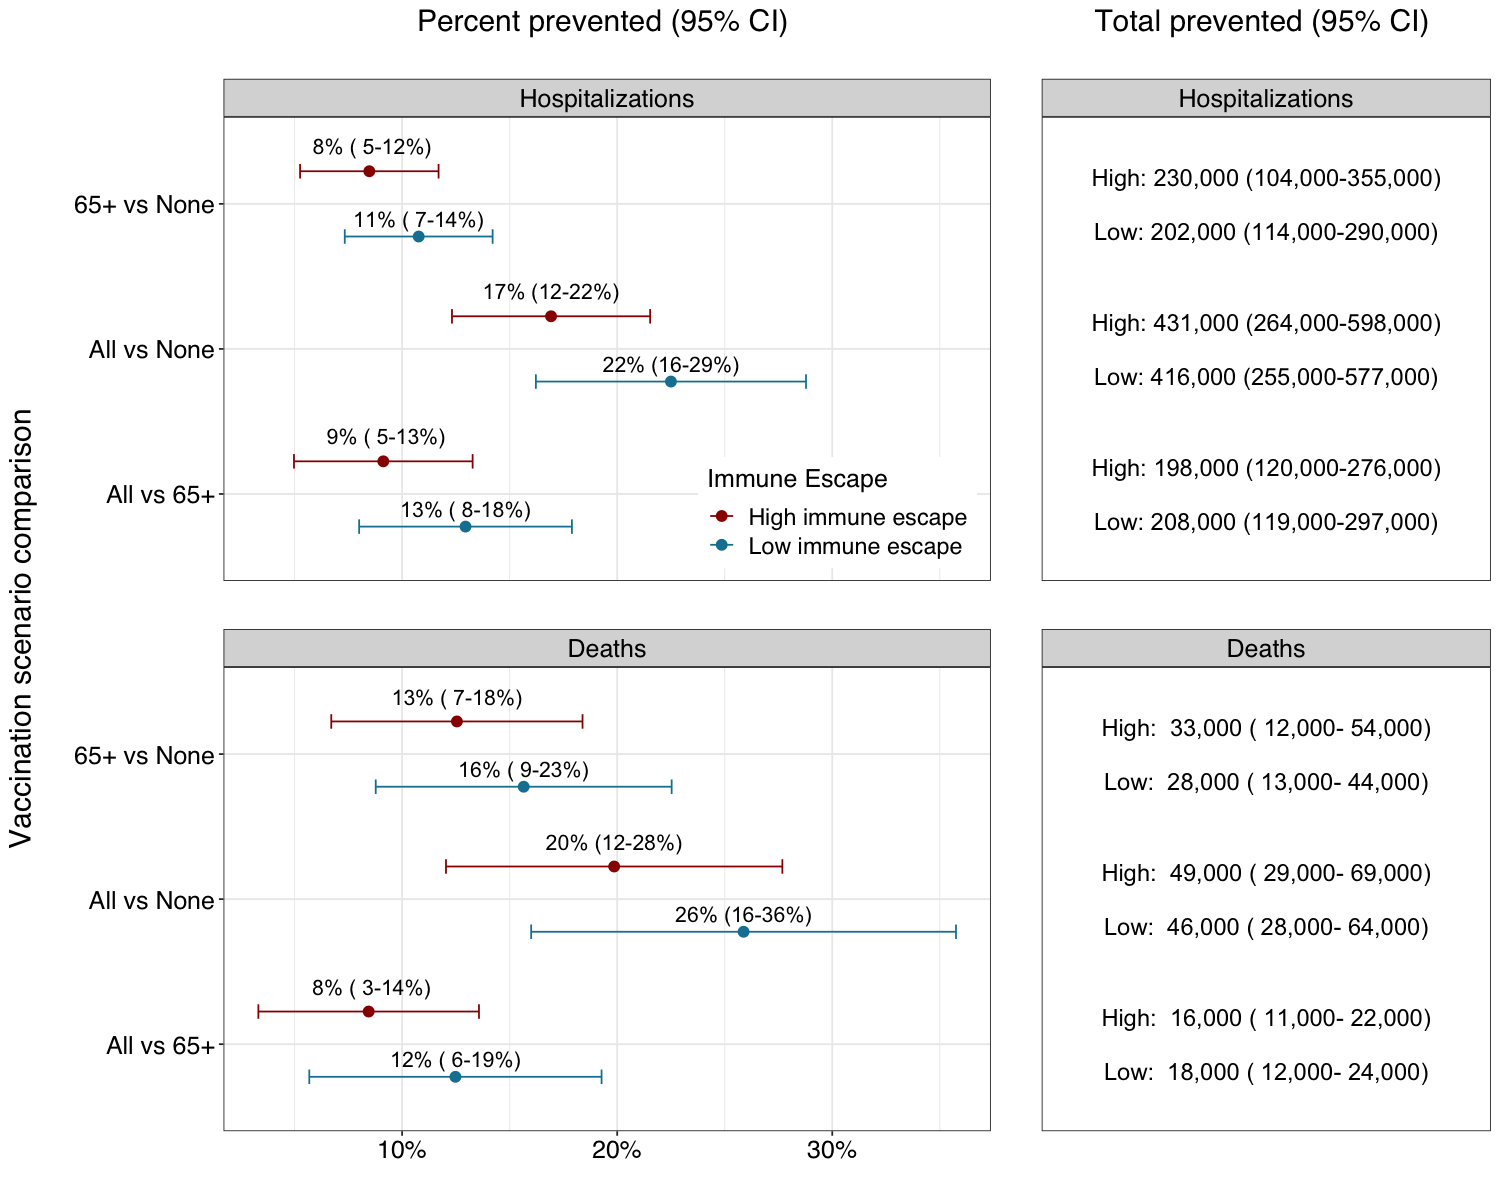

In [109]:
options(repr.plot.width=12.5,repr.plot.height=10)
cowplot::plot_grid(rel_vaccine_impact, rel_vaccine_impact_table, align = "h", nrow=1,
                   rel_widths = c(2, 1)) -> Figure2
Figure2
ggsave("Figures/Final_figures/Figure2.tiff", Figure2, width=12.5, height=10, bg='white', dpi=300)

# Figure S2 & S3 : Maximum hospitalizations  & Total deaths at the state level by season

In [110]:
df_sample <- dplyr::filter(dc, type == "sample" & (target == "inc death" |  target == "inc hosp")) %>% 
  dplyr::collect()


##filter out longer time horizons
df_sample <- df_sample %>% filter(horizon<=104)

##regreate projection date
df_sample <- df_sample %>% mutate(origin_date = lubridate::as_date(origin_date))

##Create a season indicator
##First let's recreate the projection date
df_sample <- df_sample %>%
  mutate(proj_date = origin_date + horizon*7)

##week periods
date_cuts <- c("2023-04-15","2024-04-15","2025-05-01")
date_cuts<-lubridate::as_date(date_cuts)
df_sample <- df_sample %>% 
  mutate(period=cut(proj_date, date_cuts, 
                    labels = c("April 15, 2023-April 14, 2024",
                               "April 15, 2024-April 15, 2025")))

season_res <- df_sample %>% group_by(scenario_id, target,
                                     model_name,
                                     period, location,
                                     type_id) %>%
  summarize(total=sum(value), mx=max(value)) %>%
  ungroup()


##now we get the stats to plot
season_res_sum <- season_res %>%
  group_by(scenario_id, target, model_name, period, location) %>%
  summarize(tot_median = median(total),
            tot_q975=quantile(total,0.95),
            tot_q75=quantile(total,0.75),
            tot_q25=quantile(total,0.25),
            tot_q025=quantile(total,0.05),
            mx_median = median(mx),
            mx_q975=quantile(mx,0.95),
            mx_q75=quantile(mx,0.75),
            mx_q25=quantile(mx,0.25),
            mx_q025=quantile(mx,0.05))%>%
  ungroup()

##add in overall
seas_res_overall <- season_res %>%
  group_by(scenario_id, target, period, location) %>%
  summarize(tot_median = median(total),
            tot_q975=quantile(total,0.95),
            tot_q75=quantile(total,0.75),
            tot_q25=quantile(total,0.25),
            tot_q025=quantile(total,0.05),
            mx_median = median(mx),
            mx_q975=quantile(mx,0.95),
            mx_q75=quantile(mx,0.75),
            mx_q25=quantile(mx,0.25),
            mx_q025=quantile(mx,0.05))%>%
  ungroup() %>%
  mutate(model_name="Ensemble")

season_res_sum <- bind_rows(season_res_sum, seas_res_overall)

#### Summarize in a tabular format
season_res_sum$model_name <- factor(season_res_sum$model_name,
                                    levels=c("UVA-adaptive", "UVA-EpiHiper", "UTA-ImmunoSEIRS", "USC-SIkJalpha", 
                                             "UNCC-hierbin", "NotreDame-FRED", "MOBS_NEU-GLEAM_COVID", "JHU_IDD-CovidSP", "Ensemble"))

`summarise()` has grouped output by 'scenario_id', 'target', 'model_name',
'period', 'location'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'scenario_id', 'target', 'model_name',
'period'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'scenario_id', 'target', 'period'. You can
override using the `.groups` argument.


In [111]:
read.csv("../covid19-scenario-hub_analysis/data-locations/locations.csv") %>% 
dplyr::select(abbreviation, location, population) %>%
filter(location!="US") %>% mutate(location=as.numeric(location)) -> df_loc
merge(season_res_sum %>% filter(location!="US") %>% mutate(location=as.numeric(location)), 
      df_loc, by=c("location"), all.x=TRUE) %>% 
  filter(!(abbreviation%in%c("AS", "GU", "MP", "PR", "UM", "VI"))) -> season_res_sum_loc

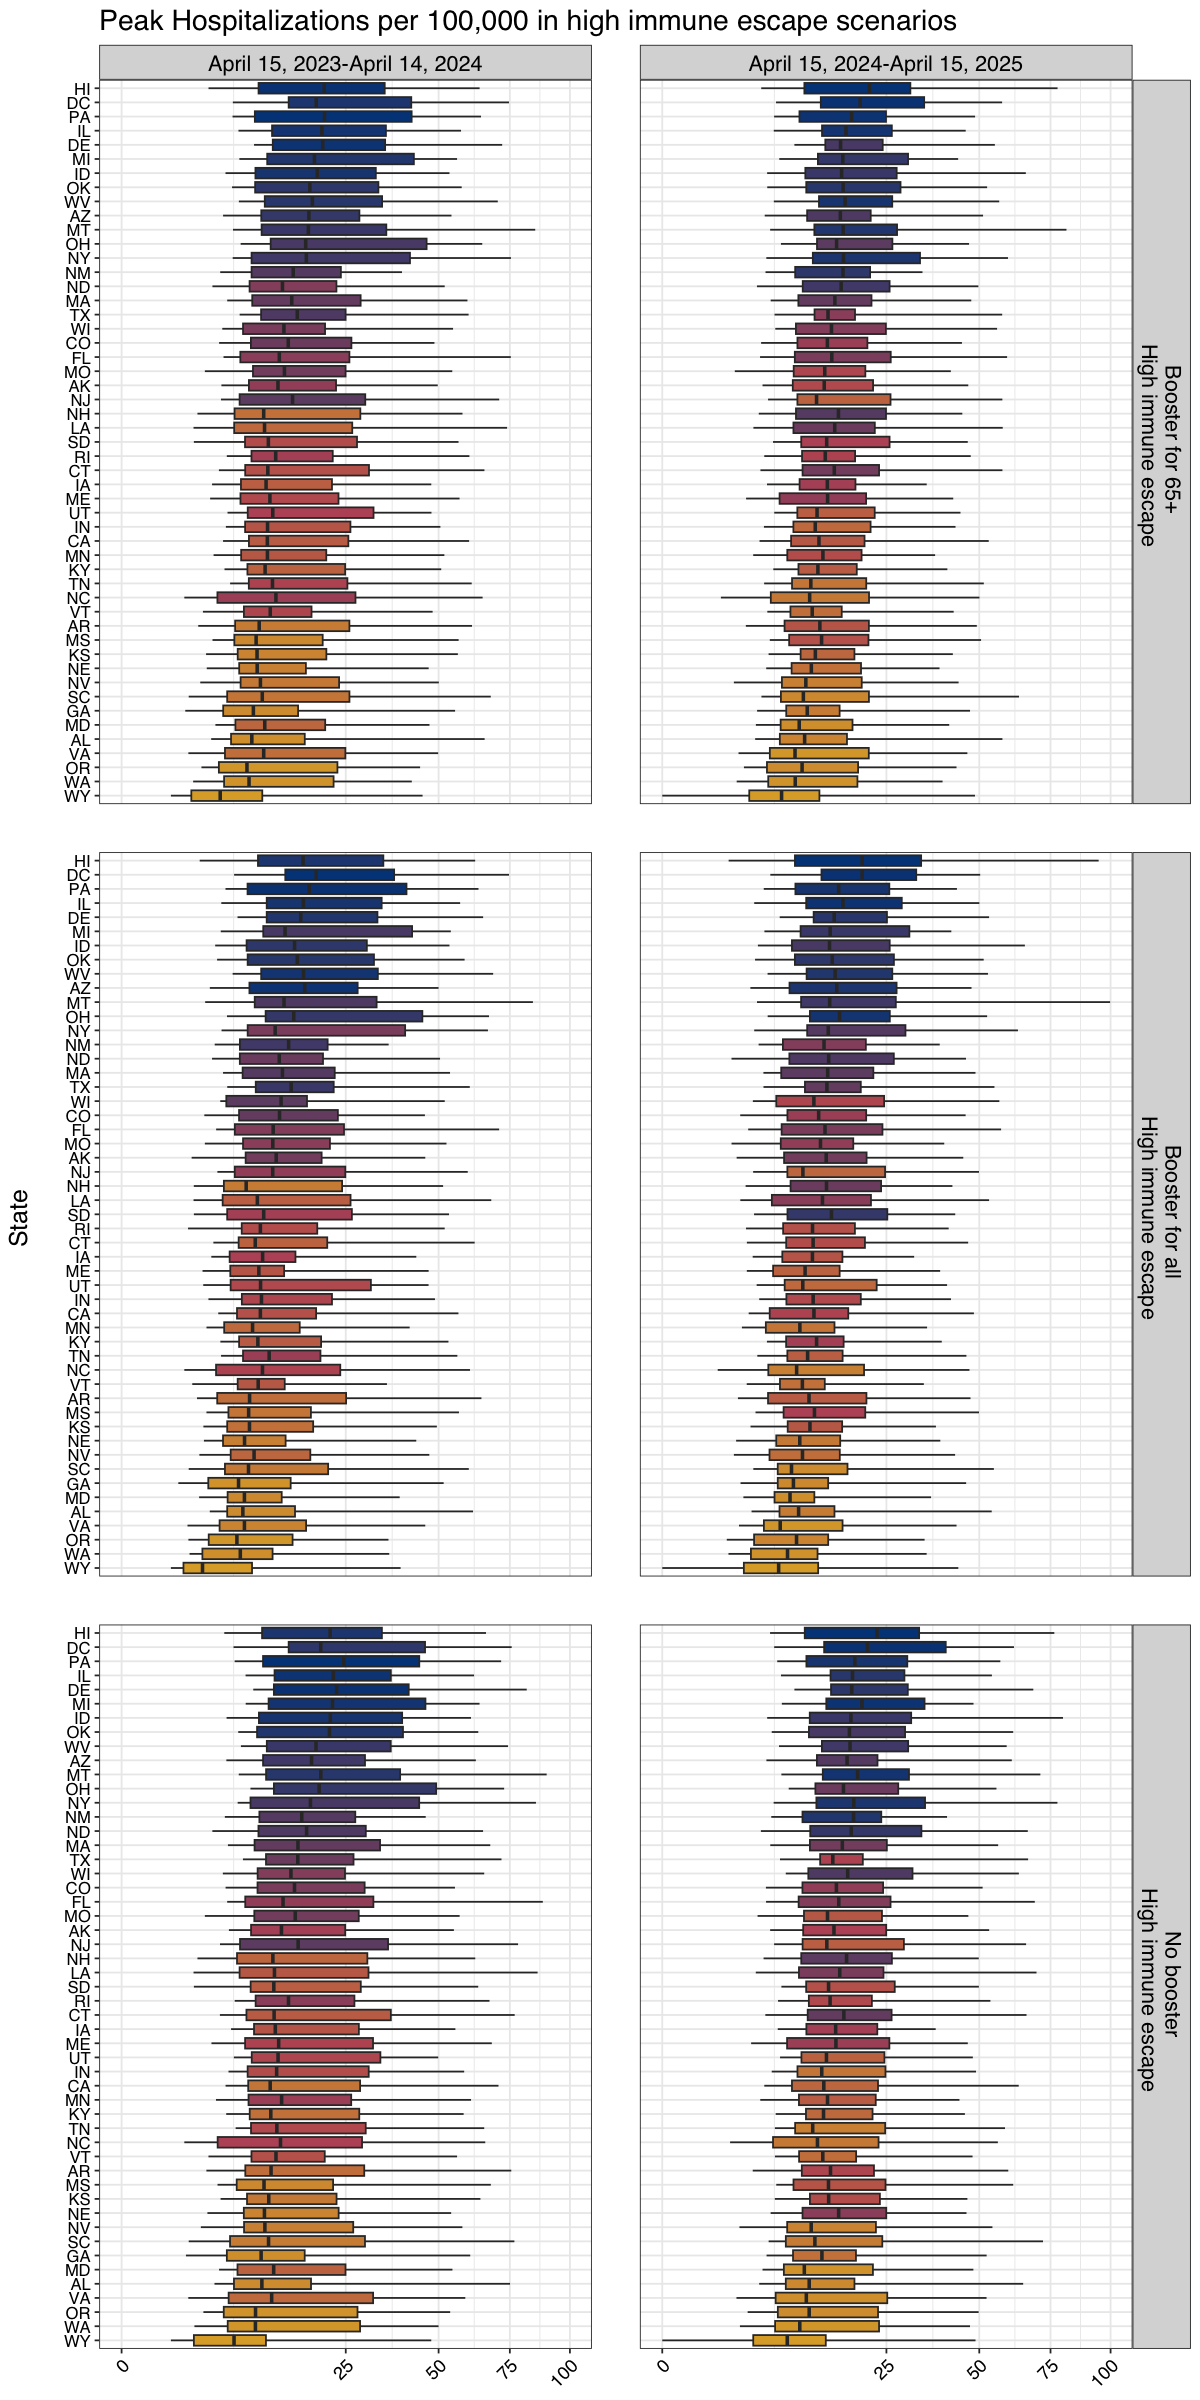

In [112]:
options(repr.plot.width=10,repr.plot.height=20)

## total deaths
season_dths_tot_plt_highI_state <- season_res_sum_loc%>%
  filter(target=="inc death", model_name=="Ensemble", scenario_id%in%c("B-2023-04-16","D-2023-04-16", "F-2023-04-16"))%>%
  mutate(scenario_id=recode(scenario_id, "B-2023-04-16" = "No booster \n High immune escape",
                            "D-2023-04-16"="Booster for 65+ \n High immune escape", 
                            "F-2023-04-16"="Booster for all \n High immune escape")) %>%
  mutate(rate=tot_median/population*100000) %>%
  ggplot(aes(x=reorder(abbreviation, rate), fill=rate))+
  scale_fill_viridis_c(option = "turbo") +
  facet_grid(rows=vars(scenario_id), cols=vars(period))+
  geom_boxplot(aes(ymin=tot_q025/population*100000, lower=tot_q25/population*100000, 
                   middle=tot_median/population*100000, upper=tot_q75/population*100000, 
                   ymax=tot_q975/population*100000), stat="identity", width=0.75) + 
  scale_y_sqrt()+
  coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
  labs(x="State \n", title="Total deaths per 100,000 individuals - High immune escape")

season_dths_tot_plt_lowI_state <- season_res_sum_loc%>%
  filter(target=="inc death", model_name=="Ensemble", scenario_id%in%c("A-2023-04-16","C-2023-04-16", "E-2023-04-16"))%>%
  mutate(scenario_id=recode(scenario_id, "A-2023-04-16" = "No booster \n Low immune escape",
                            "C-2023-04-16"="Booster for 65+ \n Low immune escape",  
                            "E-2023-04-16"="Booster for all \n Low immune escape")) %>%
  mutate(rate=tot_median/population*100000) %>% 
  ggplot(aes(x=reorder(abbreviation, rate), fill=rate))+
  scale_fill_viridis_c(option = "turbo") +
  facet_grid(rows=vars(scenario_id), cols=vars(period))+
  geom_boxplot(aes(ymin=tot_q025/population*100000, lower=tot_q25/population*100000, 
                   middle=tot_median/population*100000, upper=tot_q75/population*100000, 
                   ymax=tot_q975/population*100000), stat="identity", width=0.75) + 
  scale_y_sqrt()+
  coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
  labs(x="State \n", title="Total deaths per 100,000 individuals - Low immune escape")

ggsave("Figures/FigureS3_1.png", season_dths_tot_plt_highI_state, width=10, height=20)
ggsave("Figures/FigureS3_2.png", season_dths_tot_plt_lowI_state, width=10, height=20)

## maximum hosp 
season_hosp_mx_plt_highI_state  <- season_res_sum_loc%>%
  filter(target=="inc hosp", model_name=="Ensemble", scenario_id%in%c("B-2023-04-16","D-2023-04-16", "F-2023-04-16"))%>%
  mutate(scenario_id=recode(scenario_id, "B-2023-04-16" = "No booster \n High immune escape",
                            "D-2023-04-16"="Booster for 65+ \n High immune escape",  
                            "F-2023-04-16"="Booster for all \n High immune escape"))%>%
  mutate(rate=mx_median/population*100000) %>%
group_by(scenario_id, period) %>% arrange(rate) %>% mutate(color_order=order(rate)) %>% ungroup() %>%
  ggplot(aes(x=reorder(abbreviation, rate), fill=color_order))+
scale_fill_gradientn(colours=pal, trans = 'reverse')+
  facet_grid(rows=vars(scenario_id), cols=vars(period))+
  geom_boxplot(aes(ymin=mx_q025/population*100000, lower=mx_q25/population*100000,
                   middle=mx_median/population*100000, upper=mx_q75/population*100000, 
                   ymax=mx_q975/population*100000), stat="identity", width=0.75) + 
  scale_y_sqrt()+
  coord_flip()+
theme(legend.position="none",
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.y = element_text(size=10, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.text = element_text(size=14),
      panel.spacing = unit(2, "lines")) +
  labs(x="State \n", title="Peak Hospitalizations per 100,000 in high immune escape scenarios")

ggsave("Figures/Final_figures/FigureS2.tiff", season_hosp_mx_plt_highI_state , width=10, height=20, dpi=300)

season_hosp_mx_plt_highI_state

In [129]:
dc <- arrow::open_dataset(paste0(repo_data, folder_path), partitioning = "model_name", 
                          format = "parquet", schema = schema, 
                          factory_options = list(
                            exclude_invalid_files = TRUE))

df_quantile <- dplyr::filter(dc, type == "quantile") %>%  #& (target == "inc death" |  target == "inc hosp")
  dplyr::collect()
setDT(df_quantile)
df_quantile <- df_quantile %>%
  .[, origin_date := as.IDate(origin_date)]

# truth data (from fluview - check with Lucie)
gs_inc_hosp <- setDT(read.csv(paste0(repo_data, "visualization/data-goldstandard/hospitalization.csv"))) %>% 
  .[time_value > "2023-04-16" & time_value <= "2023-12-16"]
gs_inc_death <-  setDT(read.csv(paste0(repo_data,"visualization/data-goldstandard/fv_death_incidence_num.csv"))) %>%
  .[time_value > "2023-04-16" & time_value <= "2023-12-16"]
gold_standard_data <- rbindlist(l = list( copy(gs_inc_hosp) %>% 
                                           .[, target := "inc hosp"], 
                                         copy(gs_inc_death) %>% 
                                           .[, target := "inc death"], 
                                         copy(gs_inc_hosp) %>% 
                                           .[, value := cumsum(value), 
                                             by = .(geo_value_fullname, fips)] %>% 
                                           .[, target := "cum hosp"], 
                                         copy(gs_inc_death) %>% 
                                           .[, value := cumsum(value), 
                                             by = .(geo_value_fullname, fips)] %>% 
                                           .[, target := "cum death"])) %>%
  .[, time_value := as.IDate(time_value)] %>%
  rename(obs = "value")


# add observations to df_quantile
df_quantile <- df_quantile %>% 
  .[, time_value :=  origin_date + horizon*7-1] %>%
  .[gold_standard_data, on = .(time_value, target, location = fips)] %>%
  .[!is.na(origin_date)]

In [130]:
#### CALCULATE COVERAGE --------------------------------------------------------
cov <- data.table(alpha = c(seq(0.1, 0.9, 0.1), 0.95, 0.98))
# find upper and lower intervals for all alpha levels
cov$upr <- cov$alpha/2 + 0.5
cov$lwr <- 1-(cov$alpha/2 + 0.5)
cov <- melt(cov, "alpha", value.name = "quantile")
cov$quantile = round(cov$quantile,3)
setDT(cov)

# merge with proj to assign alpha and lwr/upr to each quantile in proj
cov <- cov[df_quantile, on = .(quantile = type_id)] %>% 
  .[quantile != 0.5] %>% 
  # reshape to make lwr and upr columnns
  data.table::dcast(origin_date + scenario_id + location + target + horizon + time_value  + 
                      model_name + alpha + obs ~ variable, value.var = "value")  %>%
  .[, ":=" (cov = ifelse(obs < upr & obs > lwr, 1, 0))] %>% 
  .[, ":=" (upr = NULL,
            lwr = NULL, 
            obs = NULL)]

#### PLOT RESULTS --------------------------------------------------------------
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}


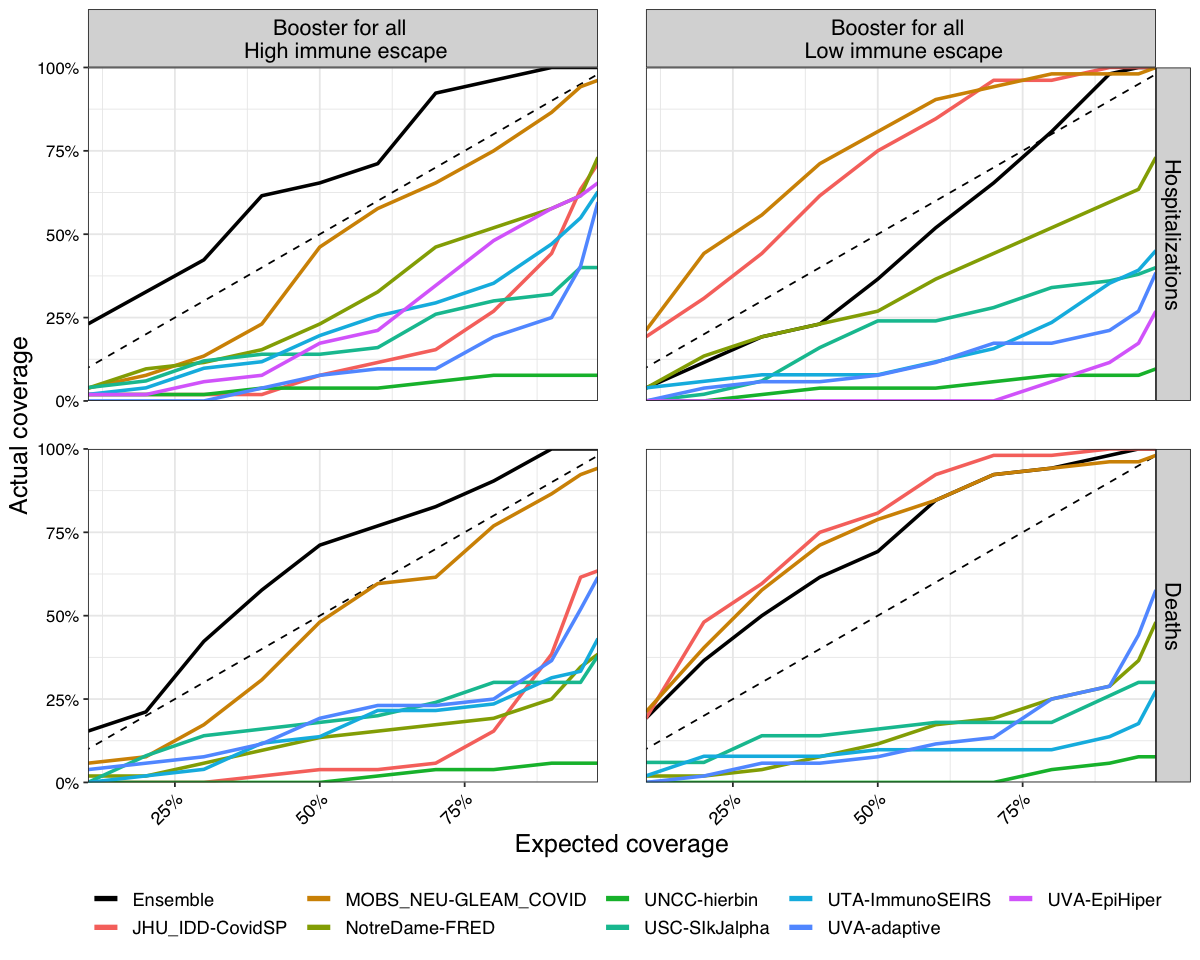

In [131]:
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

# COVERAGE ACROSS LOCATIONS AND WEEKS FOR EACH SCENARIO/TARGET
options(repr.plot.width=10,repr.plot.height=8)

cov %>%
  .[, max_time_value := max(time_value), by = .(target)] %>%
  .[!is.na(cov) &
      time_value == max_time_value &
      substr(scenario_id,1,1) %in% c("E", "F") &
      substr(target, 1,3) == "cum" &
      !(model_name %in% c("NCSU-COVSIM", "Ensemble_LOP_untrimmed", "Ensemble"))] %>%
  .[, .(cov_summ = sum(cov)/.N), 
    by = .(alpha, origin_date, target, model_name, scenario_id)] %>%

    mutate(target=case_when(target==c("cum death")~c("Deaths"), target==c("cum hosp")~c("Hospitalizations")),
           scenario_id=case_when(scenario_id==c("E-2023-04-16")~c("Booster for all \n Low immune escape"), 
                             scenario_id==c("F-2023-04-16")~c("Booster for all \n High immune escape"))) %>%
    mutate(model_name=case_when(model_name==c("Ensemble_LOP")~c("Ensemble"), TRUE~model_name)) %>%
    filter(model_name %in% c('Ensemble', 'JHU_IDD-CovidSP', 'MOBS_NEU-GLEAM_COVID', 'NotreDame-FRED', 
                             'UNCC-hierbin', 'USC-SIkJalpha', 'UTA-ImmunoSEIRS','UVA-adaptive','UVA-EpiHiper')) %>%
  ggplot(aes(x = alpha, y = cov_summ, color = model_name)) +
  geom_abline(linetype = "dashed") +
  geom_line(linewidth = 1) + 
  facet_grid(cols = vars(scenario_id), 
             rows = vars(factor(target, levels = c("Hospitalizations", "Deaths")))) + 
  labs(x = "Expected coverage", y = "Actual coverage") +
  scale_color_manual(values = c("black", gg_color_hue(9))) +
  scale_x_continuous(expand = c(0,0), label = percent) +
  scale_y_continuous(expand = c(0,0), label = percent) +
  theme_bw() + 
  theme(legend.position = "bottom", 
      text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=11, family="sans",color="black"),
      plot.title = element_text(size=17, family="sans",color="black"),
      strip.text = element_text(size = 13, family="sans",color="black"),
      axis.title.y = element_text(size=15, family="sans",color="black"),
      axis.text.y = element_text(size=10, family="sans",color="black"),
      axis.text.x = element_text(angle=45, hjust=1), 
      legend.title = element_blank(), legend.text = element_text(size=11),
      panel.spacing = unit(2, "lines")) +
guides(color = guide_legend(override.aes = list(linewidth = 1.5)))

ggsave("Figures/Final_figures/FigureS7.tiff" , width=10, height=8, bg='white', dpi=300)